In [16]:
import sys
import itertools
ON_COLAB = 0
if ON_COLAB:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive # type: ignore
    drive.mount('/content/drive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    # assignment folder, e.g. 'cs231n/assignments/assignment2/'
    FOLDERNAME = "Classroom/Machine Learning 2024-25 TUE + FRI Morn2/assignment2"
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

    # This downloads the CIFAR-10 dataset to your Drive
    # if it doesn't already exist.
    %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
    !bash get_datasets.sh
    %cd /content/drive/My\ Drive/$FOLDERNAME
else:
    %cd cs231n/datasets/
    !bash get_datasets.sh
    %cd ../../

/Users/aayanarish/Downloads/fun-ds-stuff/Projects/Outgoing Projects/school/2024-2025/Machine Learning/assignment2/cs231n/datasets
/Users/aayanarish/Downloads/fun-ds-stuff/Projects/Outgoing Projects/school/2024-2025/Machine Learning/assignment2


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [49]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [5]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dropout_keep_ratio=1,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.2120479295080622e-05
W3 relative error: 4.5623278736665505e-07
b1 relative error: 4.6600944653202505e-09
b2 relative error: 2.085654276112763e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.226194231455292
W1 relative error: 2.4148437214897525e-08
W2 relative error: 5.684526292112292e-08
W3 relative error: 4.28085884985768e-08
b1 relative error: 9.342582185897802e-09
b2 relative error: 2.9514104484530754e-08
b3 relative error: 1.3090667159637862e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

  2%|▎         | 1/40 [00:00<00:06,  5.66it/s]

(Iteration 1 / 40) loss: 2.302191
(Epoch 0 / 20) train acc: 0.320000; val_acc: 0.118000
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.123000
(Epoch 2 / 20) train acc: 0.340000; val_acc: 0.134000


 35%|███▌      | 14/40 [00:00<00:00, 38.35it/s]

(Epoch 3 / 20) train acc: 0.480000; val_acc: 0.143000
(Epoch 4 / 20) train acc: 0.440000; val_acc: 0.149000
(Epoch 5 / 20) train acc: 0.600000; val_acc: 0.172000
(Iteration 11 / 40) loss: 1.045162
(Epoch 6 / 20) train acc: 0.680000; val_acc: 0.183000
(Epoch 7 / 20) train acc: 0.720000; val_acc: 0.161000


 65%|██████▌   | 26/40 [00:00<00:00, 47.49it/s]

(Epoch 8 / 20) train acc: 0.760000; val_acc: 0.167000
(Epoch 9 / 20) train acc: 0.840000; val_acc: 0.197000
(Epoch 10 / 20) train acc: 0.800000; val_acc: 0.173000
(Iteration 21 / 40) loss: 0.609338
(Epoch 11 / 20) train acc: 0.880000; val_acc: 0.180000
(Epoch 12 / 20) train acc: 0.880000; val_acc: 0.185000
(Epoch 13 / 20) train acc: 0.900000; val_acc: 0.205000


 90%|█████████ | 36/40 [00:00<00:00, 47.21it/s]

(Epoch 14 / 20) train acc: 0.900000; val_acc: 0.191000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.203000
(Iteration 31 / 40) loss: 0.185847
(Epoch 16 / 20) train acc: 0.960000; val_acc: 0.187000
(Epoch 17 / 20) train acc: 1.000000; val_acc: 0.191000
(Epoch 18 / 20) train acc: 1.000000; val_acc: 0.194000


100%|██████████| 40/40 [00:00<00:00, 42.18it/s]


(Epoch 19 / 20) train acc: 1.000000; val_acc: 0.194000
(Epoch 20 / 20) train acc: 0.980000; val_acc: 0.218000


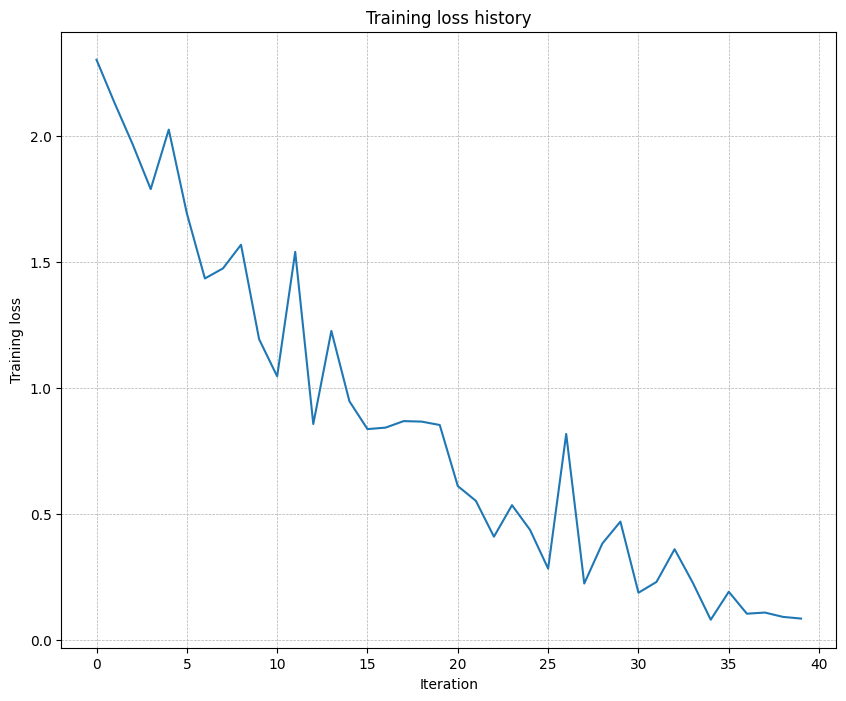

In [76]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 7e-3  # Experiment with this!
model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64,
    dropout_keep_ratio=1
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

  2%|▎         | 1/40 [00:00<00:08,  4.82it/s]

(Iteration 1 / 40) loss: 27.302333
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.116000


 30%|███       | 12/40 [00:00<00:00, 35.15it/s]

(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.140000; val_acc: 0.106000
(Epoch 3 / 20) train acc: 0.160000; val_acc: 0.088000
(Epoch 4 / 20) train acc: 0.180000; val_acc: 0.122000
(Epoch 5 / 20) train acc: 0.220000; val_acc: 0.126000
(Iteration 11 / 40) loss: 2.248053
(Epoch 6 / 20) train acc: 0.460000; val_acc: 0.143000


 45%|████▌     | 18/40 [00:00<00:00, 39.85it/s]

(Epoch 7 / 20) train acc: 0.440000; val_acc: 0.140000
(Epoch 8 / 20) train acc: 0.520000; val_acc: 0.145000
(Epoch 9 / 20) train acc: 0.580000; val_acc: 0.154000
(Epoch 10 / 20) train acc: 0.640000; val_acc: 0.142000
(Iteration 21 / 40) loss: 1.579082
(Epoch 11 / 20) train acc: 0.640000; val_acc: 0.126000


 75%|███████▌  | 30/40 [00:00<00:00, 46.63it/s]

(Epoch 12 / 20) train acc: 0.720000; val_acc: 0.143000
(Epoch 13 / 20) train acc: 0.740000; val_acc: 0.125000
(Epoch 14 / 20) train acc: 0.720000; val_acc: 0.147000
(Epoch 15 / 20) train acc: 0.800000; val_acc: 0.142000
(Iteration 31 / 40) loss: 0.557739
(Epoch 16 / 20) train acc: 0.800000; val_acc: 0.139000
(Epoch 17 / 20) train acc: 0.820000; val_acc: 0.140000


100%|██████████| 40/40 [00:01<00:00, 38.60it/s]

(Epoch 18 / 20) train acc: 0.860000; val_acc: 0.150000
(Epoch 19 / 20) train acc: 0.900000; val_acc: 0.146000
(Epoch 20 / 20) train acc: 0.900000; val_acc: 0.142000


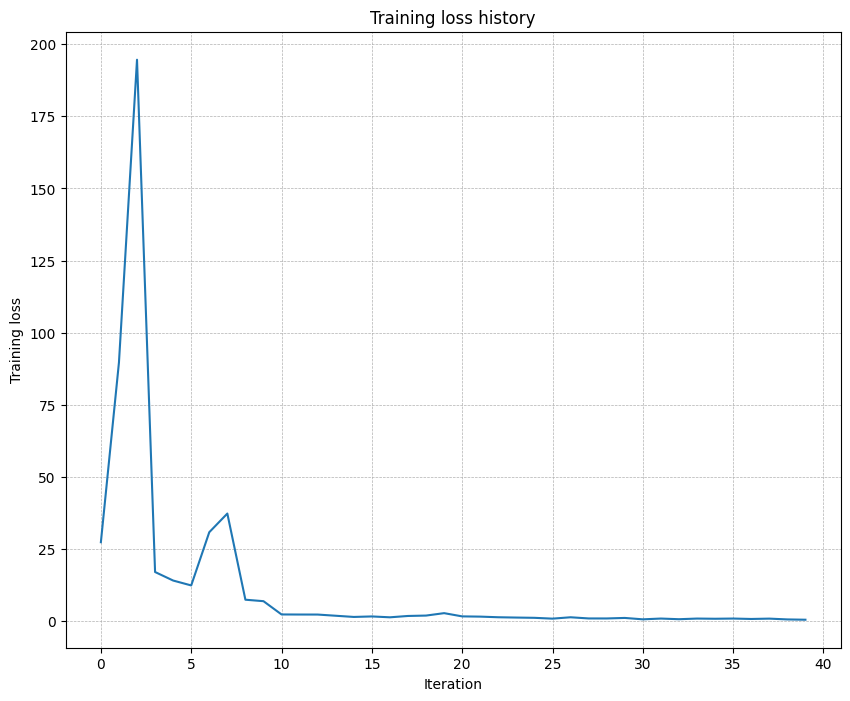

In [71]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-2  # Experiment with this!
weight_scale = 7e-2   # Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1: 
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
5 layer seems more sensitive to weight initialization scale. maybe cause there are more nodes that can be sensitive to the inital weight and that just leads to overall extra sensitivity. 


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [8]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.955135
(Epoch 0 / 5) train acc: 0.092000; val_acc: 0.080000
(Iteration 11 / 200) loss: 2.251921
(Iteration 21 / 200) loss: 2.189223
(Iteration 31 / 200) loss: 2.062878
(Epoch 1 / 5) train acc: 0.233000; val_acc: 0.239000
(Iteration 41 / 200) loss: 2.026723
(Iteration 51 / 200) loss: 2.070143
(Iteration 61 / 200) loss: 2.068588
(Iteration 71 / 200) loss: 2.042431
(Epoch 2 / 5) train acc: 0.288000; val_acc: 0.288000
(Iteration 81 / 200) loss: 2.024892
(Iteration 91 / 200) loss: 1.995659
(Iteration 101 / 200) loss: 1.905020
(Iteration 111 / 200) loss: 1.819794
(Epoch 3 / 5) train acc: 0.333000; val_acc: 0.308000
(Iteration 121 / 200) loss: 1.871935
(Iteration 131 / 200) loss: 1.873120
(Iteration 141 / 200) loss: 1.955543
(Iteration 151 / 200) loss: 1.804442
(Epoch 4 / 5) train acc: 0.331000; val_acc: 0.293000
(Iteration 161 / 200) loss: 1.858237
(Iteration 171 / 200) loss: 1.942870
(Iteration 181 / 200) loss: 1.677802
(Iteration 191 / 200) los

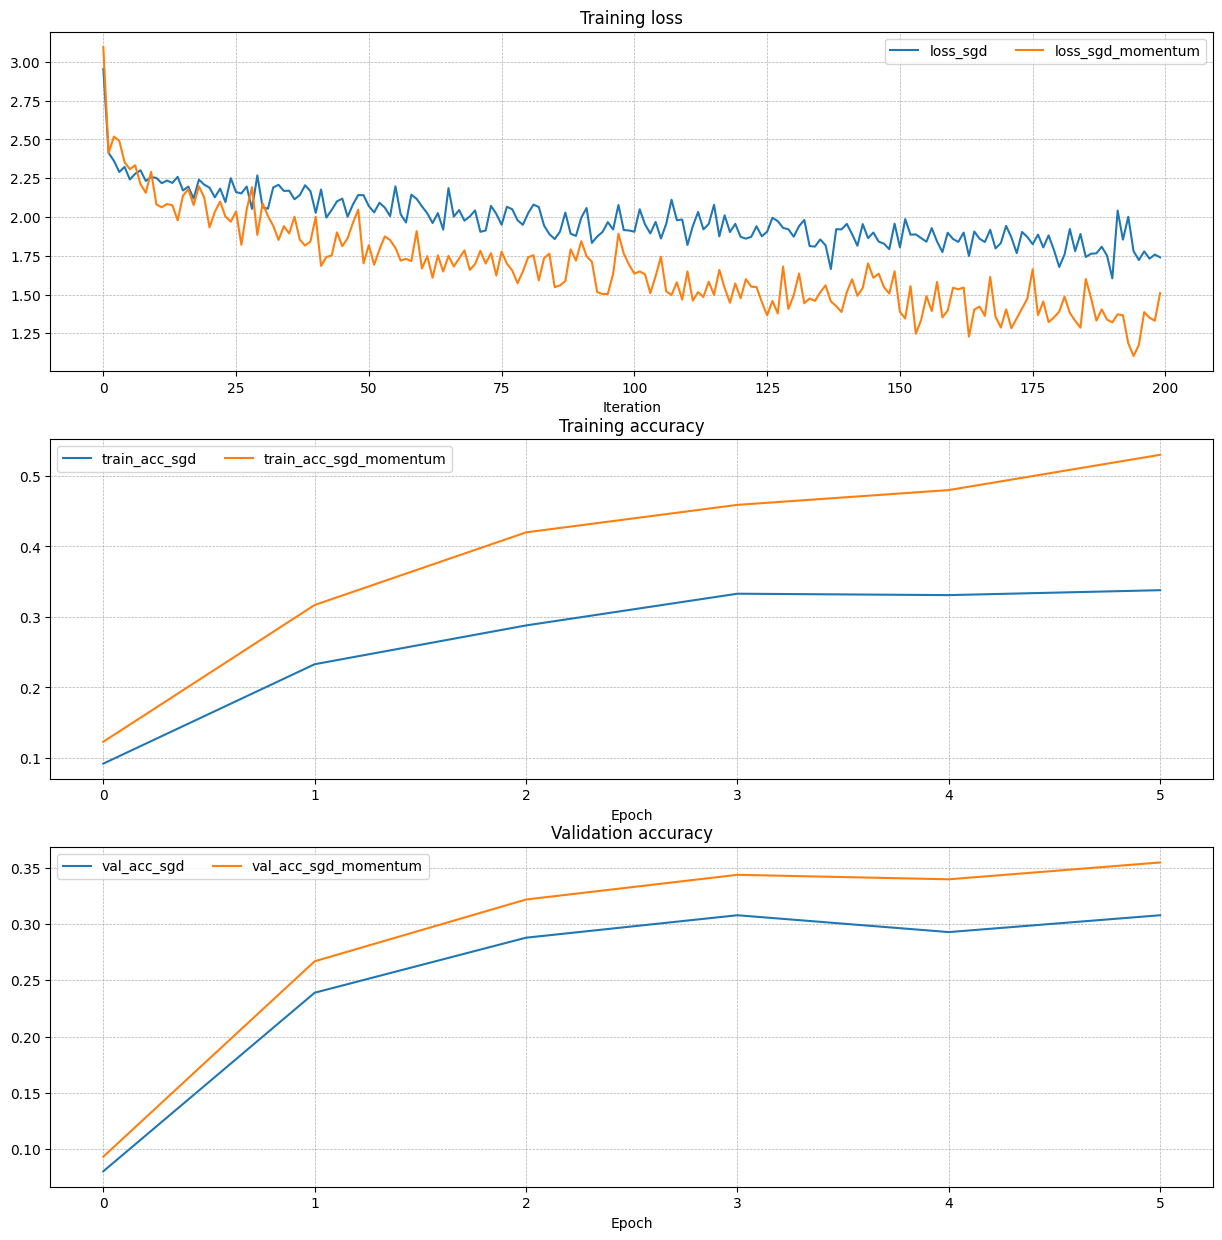

In [9]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [10]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [11]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.139887467333134e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [59]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# layers = [100]*7
# n_epochs=10
# weight_scale = 2e-2
# lr = 10**(-3.5)
num_train = 10000
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
  }
all_data = {
    'X_train': data['X_train'],
    'y_train': data['y_train'],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
  }
def hyperparamtune(
    layerss,
    epochs,
    weight_scales,
    batch_sizes,
    lrs,
    dropout_rat,
    regs,
    use_bn,
    data,
):
  bst = None
  bstprms = None
  bst_prd = 0
  for l, ep, rat, ws, bs, lr, reg, ubn in itertools.product(layerss, epochs, dropout_rat, weight_scales, batch_sizes, lrs, regs, use_bn):
    model = FullyConnectedNet(
        hidden_dims=l, 
        dropout_keep_ratio=rat,
        normalization=("batchnorm" if ubn else None),
        reg=reg,
        weight_scale=ws
    )
    solver = Solver(
      model, 
      data,
      num_epochs=ep, batch_size=bs,
      update_rule='adam',
      optim_config={
        'learning_rate': lr,
      },
      verbose=False
    )
    solver.train()

    y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
    y_val_pred = (y_val_pred == data['y_val']).mean()
    print(
      "Done parameters:", 
      f"Layers: {l}",
      f"Epochs: {ep}",
      f"Weight Scale: {ws}",
      f"Batch Size: {bs}",
      f"Learning Rate: {lr}",
      f"Dropout: {rat}",
      f"Reg: {reg}",
      f"Using Batch Norm: {bool(ubn)}",
      f"Accuracy: {y_val_pred}",
      sep="\n\t"
    )
    if y_val_pred > bst_prd:
      bst = model
      bst_prd = y_val_pred
      bstprms = (bs, lr)

  return bst, bstprms

best_model, (batchsz, lr) = hyperparamtune(
  layerss=[[2000]*2],
  epochs=[30],
  weight_scales=[1e-1, 6e-2, 2e-2],
  lrs=[3e-4],
  batch_sizes=[300],
  dropout_rat=[0.4],
  regs=[0],
  use_bn = [1],
  data=small_data
)

epochs = 50
solvr = Solver(
  best_model, 
  all_data, 
  num_epochs=epochs, 
  batch_size=batchsz,
  update_rule='adam',
  optim_config={
    'learning_rate': lr,
  },
  verbose=True,
  print_every=500
)
solvr.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

100%|██████████| 990/990 [38:48<00:00,  2.35s/it]   


Done parameters:
	Layers: [2000, 2000]
	Epochs: 30
	Weight Scale: 0.1
	Batch Size: 300
	Learning Rate: 0.0003
	Dropout: 0.4
	Reg: 0
	Using Batch Norm: True
	Accuracy: 0.467


100%|██████████| 990/990 [03:01<00:00,  5.44it/s]


Done parameters:
	Layers: [2000, 2000]
	Epochs: 30
	Weight Scale: 0.06
	Batch Size: 300
	Learning Rate: 0.0003
	Dropout: 0.4
	Reg: 0
	Using Batch Norm: True
	Accuracy: 0.494


100%|██████████| 990/990 [03:00<00:00,  5.49it/s]


Done parameters:
	Layers: [2000, 2000]
	Epochs: 30
	Weight Scale: 0.02
	Batch Size: 300
	Learning Rate: 0.0003
	Dropout: 0.4
	Reg: 0
	Using Batch Norm: True
	Accuracy: 0.486


  0%|          | 0/8150 [00:00<?, ?it/s]

(Iteration 1 / 8150) loss: 1.919328


  0%|          | 2/8150 [00:00<42:51,  3.17it/s]  

(Epoch 0 / 50) train acc: 0.541000; val_acc: 0.496000


  2%|▏         | 164/8150 [00:30<30:27,  4.37it/s]

(Epoch 1 / 50) train acc: 0.560000; val_acc: 0.509000


  4%|▍         | 326/8150 [00:59<32:45,  3.98it/s]

(Epoch 2 / 50) train acc: 0.534000; val_acc: 0.525000


  6%|▌         | 490/8150 [01:28<28:59,  4.40it/s]

(Epoch 3 / 50) train acc: 0.549000; val_acc: 0.527000


  6%|▌         | 502/8150 [01:30<22:32,  5.66it/s]

(Iteration 501 / 8150) loss: 1.706074


  8%|▊         | 652/8150 [01:56<29:29,  4.24it/s]

(Epoch 4 / 50) train acc: 0.563000; val_acc: 0.534000


 10%|█         | 816/8150 [02:25<26:36,  4.59it/s]

(Epoch 5 / 50) train acc: 0.577000; val_acc: 0.528000


 12%|█▏        | 979/8150 [02:53<25:29,  4.69it/s]

(Epoch 6 / 50) train acc: 0.580000; val_acc: 0.542000


 12%|█▏        | 1002/8150 [02:57<20:48,  5.72it/s]

(Iteration 1001 / 8150) loss: 1.527077


 14%|█▍        | 1142/8150 [03:22<26:33,  4.40it/s]

(Epoch 7 / 50) train acc: 0.574000; val_acc: 0.531000


 16%|█▌        | 1305/8150 [03:51<24:37,  4.63it/s]

(Epoch 8 / 50) train acc: 0.601000; val_acc: 0.532000


 18%|█▊        | 1468/8150 [04:20<24:34,  4.53it/s]

(Epoch 9 / 50) train acc: 0.608000; val_acc: 0.556000


 18%|█▊        | 1502/8150 [04:26<18:14,  6.07it/s]

(Iteration 1501 / 8150) loss: 1.542862


 20%|██        | 1631/8150 [04:48<23:30,  4.62it/s]

(Epoch 10 / 50) train acc: 0.618000; val_acc: 0.550000


 22%|██▏       | 1794/8150 [05:17<23:07,  4.58it/s]

(Epoch 11 / 50) train acc: 0.597000; val_acc: 0.539000


 24%|██▍       | 1957/8150 [05:45<22:03,  4.68it/s]

(Epoch 12 / 50) train acc: 0.635000; val_acc: 0.557000


 25%|██▍       | 2002/8150 [05:52<16:37,  6.17it/s]

(Iteration 2001 / 8150) loss: 1.227784


 26%|██▌       | 2120/8150 [06:13<22:51,  4.40it/s]

(Epoch 13 / 50) train acc: 0.627000; val_acc: 0.559000


 28%|██▊       | 2283/8150 [06:41<20:53,  4.68it/s]

(Epoch 14 / 50) train acc: 0.622000; val_acc: 0.573000


 30%|███       | 2446/8150 [07:09<20:12,  4.70it/s]

(Epoch 15 / 50) train acc: 0.630000; val_acc: 0.579000


 31%|███       | 2502/8150 [07:19<15:23,  6.12it/s]

(Iteration 2501 / 8150) loss: 1.199279


 32%|███▏      | 2609/8150 [07:37<20:45,  4.45it/s]

(Epoch 16 / 50) train acc: 0.632000; val_acc: 0.563000


 34%|███▍      | 2772/8150 [08:05<19:30,  4.59it/s]

(Epoch 17 / 50) train acc: 0.645000; val_acc: 0.573000


 36%|███▌      | 2935/8150 [08:34<18:17,  4.75it/s]

(Epoch 18 / 50) train acc: 0.656000; val_acc: 0.574000


 37%|███▋      | 3002/8150 [08:46<14:50,  5.78it/s]

(Iteration 3001 / 8150) loss: 1.102265


 38%|███▊      | 3098/8150 [09:02<18:23,  4.58it/s]

(Epoch 19 / 50) train acc: 0.669000; val_acc: 0.567000


 40%|████      | 3261/8150 [09:30<17:38,  4.62it/s]

(Epoch 20 / 50) train acc: 0.678000; val_acc: 0.577000


 42%|████▏     | 3424/8150 [09:58<17:00,  4.63it/s]

(Epoch 21 / 50) train acc: 0.684000; val_acc: 0.578000


 43%|████▎     | 3502/8150 [10:11<12:40,  6.11it/s]

(Iteration 3501 / 8150) loss: 1.161548


 44%|████▍     | 3587/8150 [10:27<18:53,  4.03it/s]

(Epoch 22 / 50) train acc: 0.685000; val_acc: 0.567000


 46%|████▌     | 3750/8150 [10:56<15:43,  4.66it/s]

(Epoch 23 / 50) train acc: 0.678000; val_acc: 0.576000


 48%|████▊     | 3913/8150 [11:24<15:18,  4.61it/s]

(Epoch 24 / 50) train acc: 0.697000; val_acc: 0.583000


 49%|████▉     | 4002/8150 [11:39<11:55,  5.80it/s]

(Iteration 4001 / 8150) loss: 1.097054


 50%|█████     | 4075/8150 [11:53<24:03,  2.82it/s]

(Epoch 25 / 50) train acc: 0.672000; val_acc: 0.585000


 52%|█████▏    | 4238/8150 [12:25<16:10,  4.03it/s]

(Epoch 26 / 50) train acc: 0.726000; val_acc: 0.579000


 54%|█████▍    | 4402/8150 [12:55<13:23,  4.67it/s]

(Epoch 27 / 50) train acc: 0.701000; val_acc: 0.579000


 55%|█████▌    | 4502/8150 [13:12<10:57,  5.55it/s]

(Iteration 4501 / 8150) loss: 1.029459


 56%|█████▌    | 4565/8150 [13:23<12:27,  4.80it/s]

(Epoch 28 / 50) train acc: 0.710000; val_acc: 0.582000


 58%|█████▊    | 4728/8150 [13:52<12:41,  4.49it/s]

(Epoch 29 / 50) train acc: 0.714000; val_acc: 0.584000


 60%|██████    | 4891/8150 [14:20<11:41,  4.64it/s]

(Epoch 30 / 50) train acc: 0.721000; val_acc: 0.575000


 61%|██████▏   | 5002/8150 [14:39<09:15,  5.66it/s]

(Iteration 5001 / 8150) loss: 1.070730


 62%|██████▏   | 5054/8150 [14:48<11:10,  4.62it/s]

(Epoch 31 / 50) train acc: 0.717000; val_acc: 0.592000


 64%|██████▍   | 5216/8150 [15:15<11:02,  4.43it/s]

(Epoch 32 / 50) train acc: 0.729000; val_acc: 0.575000


 66%|██████▌   | 5380/8150 [15:44<10:08,  4.55it/s]

(Epoch 33 / 50) train acc: 0.735000; val_acc: 0.593000


 68%|██████▊   | 5502/8150 [16:05<07:23,  5.97it/s]

(Iteration 5501 / 8150) loss: 0.862533


 68%|██████▊   | 5543/8150 [16:12<09:23,  4.63it/s]

(Epoch 34 / 50) train acc: 0.765000; val_acc: 0.583000


 70%|███████   | 5706/8150 [16:41<09:06,  4.47it/s]

(Epoch 35 / 50) train acc: 0.740000; val_acc: 0.597000


 72%|███████▏  | 5869/8150 [17:09<08:28,  4.48it/s]

(Epoch 36 / 50) train acc: 0.756000; val_acc: 0.593000


 74%|███████▎  | 6002/8150 [17:31<06:09,  5.81it/s]

(Iteration 6001 / 8150) loss: 1.014862


 74%|███████▍  | 6032/8150 [17:37<07:35,  4.65it/s]

(Epoch 37 / 50) train acc: 0.782000; val_acc: 0.590000


 76%|███████▌  | 6195/8150 [18:05<06:56,  4.69it/s]

(Epoch 38 / 50) train acc: 0.758000; val_acc: 0.589000


 78%|███████▊  | 6358/8150 [18:33<06:40,  4.47it/s]

(Epoch 39 / 50) train acc: 0.756000; val_acc: 0.589000


 80%|███████▉  | 6502/8150 [18:58<05:04,  5.42it/s]

(Iteration 6501 / 8150) loss: 0.998344


 80%|████████  | 6521/8150 [19:01<05:56,  4.57it/s]

(Epoch 40 / 50) train acc: 0.773000; val_acc: 0.586000


 82%|████████▏ | 6684/8150 [19:32<05:37,  4.34it/s]

(Epoch 41 / 50) train acc: 0.758000; val_acc: 0.584000


 84%|████████▍ | 6847/8150 [20:01<05:14,  4.14it/s]

(Epoch 42 / 50) train acc: 0.750000; val_acc: 0.601000


 86%|████████▌ | 7002/8150 [20:29<03:11,  5.99it/s]

(Iteration 7001 / 8150) loss: 0.941650


 86%|████████▌ | 7010/8150 [20:31<04:49,  3.94it/s]

(Epoch 43 / 50) train acc: 0.789000; val_acc: 0.597000


 88%|████████▊ | 7173/8150 [21:01<03:33,  4.57it/s]

(Epoch 44 / 50) train acc: 0.787000; val_acc: 0.601000


 90%|█████████ | 7336/8150 [21:29<02:57,  4.58it/s]

(Epoch 45 / 50) train acc: 0.814000; val_acc: 0.597000


 92%|█████████▏| 7499/8150 [21:57<02:34,  4.21it/s]

(Epoch 46 / 50) train acc: 0.822000; val_acc: 0.592000


 92%|█████████▏| 7502/8150 [21:58<02:11,  4.93it/s]

(Iteration 7501 / 8150) loss: 0.947747


 94%|█████████▍| 7662/8150 [22:27<01:55,  4.23it/s]

(Epoch 47 / 50) train acc: 0.805000; val_acc: 0.605000


 96%|█████████▌| 7825/8150 [22:56<01:16,  4.23it/s]

(Epoch 48 / 50) train acc: 0.801000; val_acc: 0.581000


 98%|█████████▊| 7988/8150 [23:23<00:36,  4.46it/s]

(Epoch 49 / 50) train acc: 0.823000; val_acc: 0.605000


 98%|█████████▊| 8002/8150 [23:26<00:25,  5.79it/s]

(Iteration 8001 / 8150) loss: 0.950504


100%|██████████| 8150/8150 [23:52<00:00,  5.69it/s]

(Epoch 50 / 50) train acc: 0.819000; val_acc: 0.592000


# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [77]:
y_train_pred = np.argmax(best_model.loss(data['X_train']), axis=1)
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())
print('Train set accuracy: ', (y_train_pred == data['y_train']).mean())

Validation set accuracy:  0.61
Test set accuracy:  0.585
Train set accuracy:  0.8042857142857143
